## Importación de librerías

In [1]:
# Manipulación de datos
import numpy as np
import pandas as pd
import math

# Estadística y normalización
from scipy.stats import zscore
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, LabelEncoder
from category_encoders import TargetEncoder

# Visualización
import matplotlib.pyplot as plt
import seaborn as sns

## Carga de datos

In [2]:
df = pd.read_csv('HR_Employee_Attrition_EDA.csv', index_col=0)

df.head()

,Education,EducationField,Gender,MaritalStatus,Age,YearsSinceLastPromotion,YearsWithCurrManager,TotalWorkingYears,NumCompaniesWorked,Country,...,JobLevel,JobRole,MonthlyIncome,OverTime,PercentSalaryHike,TrainingTimesLastYear,EnvironmentSatisfaction,JobInvolvement,JobSatisfaction,RelationshipSatisfaction
0,Bachelor,Other,Male,Single,19,0,0,1,1.0,Austria,...,1,Sales Representative,2121,Yes,13,3,Very High,Medium,Medium,Medium
1,College,Technical Degree,Female,Married,30,0,0,4,7.0,España,...,2,Sales Executive,4736,Yes,12,2,Very High,High,High,Medium
2,College,Life Sciences,Male,Single,22,0,0,4,0.0,República Checa,...,1,Research Scientist,3375,No,12,2,Very High,High,High,Very High
3,College,Technical Degree,Male,Married,42,1,5,22,1.0,Misisipi,...,5,Manager,19232,No,11,3,High,High,Very High,Very High
4,Master,Life Sciences,Female,Single,36,0,7,17,3.0,Portugal,...,2,Sales Representative,4502,No,15,2,High,High,Very High,High


## Gestión de nulos

In [6]:
# Identificación de valores nulos en el DataFrame
cantidad_nulos = df.isna().sum()  # Suma valores nulos por columna
cantidad_nulos = cantidad_nulos[cantidad_nulos != 0]  # Filtra solo columnas con valores nulos

cantidad_nulos  # Muestra el resultado

Education                   210
NumCompaniesWorked           16
BusinessTravel              147
JobSatisfaction             191
RelationshipSatisfaction     31
dtype: int64

In [10]:
# Análisis de valores únicos en columnas categóricas con valores nulos
for col in cantidad_nulos.index.to_list():
    if col in df.select_dtypes(include='object'):
        display(df[col].value_counts())

Education
Bachelor         479
Master           353
College          243
Below College    142
Doctor            43
Name: count, dtype: int64

BusinessTravel
Travel_Rarely        941
Travel_Frequently    250
Non-Travel           132
Name: count, dtype: int64

JobSatisfaction
Very High    400
High         381
Low          257
Medium       241
Name: count, dtype: int64

RelationshipSatisfaction
High         450
Very High    423
Medium       297
Low          269
Name: count, dtype: int64

### Imputación de nulos

Para las columnas categóricas (como nivel educativo, viajes de negocios y medidas de satisfacción), se utiliza el valor genérico "Unknown" para reemplazar los valores nulos.
Para la columna numérica `NumCompaniesWorked`, se utiliza la mediana como medida de tendencia central para reemplazar los valores faltantes.

Esta estrategia de imputación preserva la integridad del conjunto de datos mientras proporciona un tratamiento apropiado según el tipo de variable, evitando la eliminación de filas con información parcialmente completa.

In [11]:
# Valor desconocido
val = 'Unknown'

# Columnas categoricas
cols_cat = ['Education', 'BusinessTravel', 'JobSatisfaction', 'RelationshipSatisfaction']

# Imputación de valores categóricos con un valor desconocido
df[cols_cat] = df[cols_cat].fillna(val)

# Imputación de valores numéricos con la mediana
df['NumCompaniesWorked'] = df['NumCompaniesWorked'].fillna(df['NumCompaniesWorked'].median())

In [15]:
# Comprobación de nulos
df.isna().sum().sum()

np.int64(0)

## Gestión outliers

### Identificación de outliers mediante boxplot

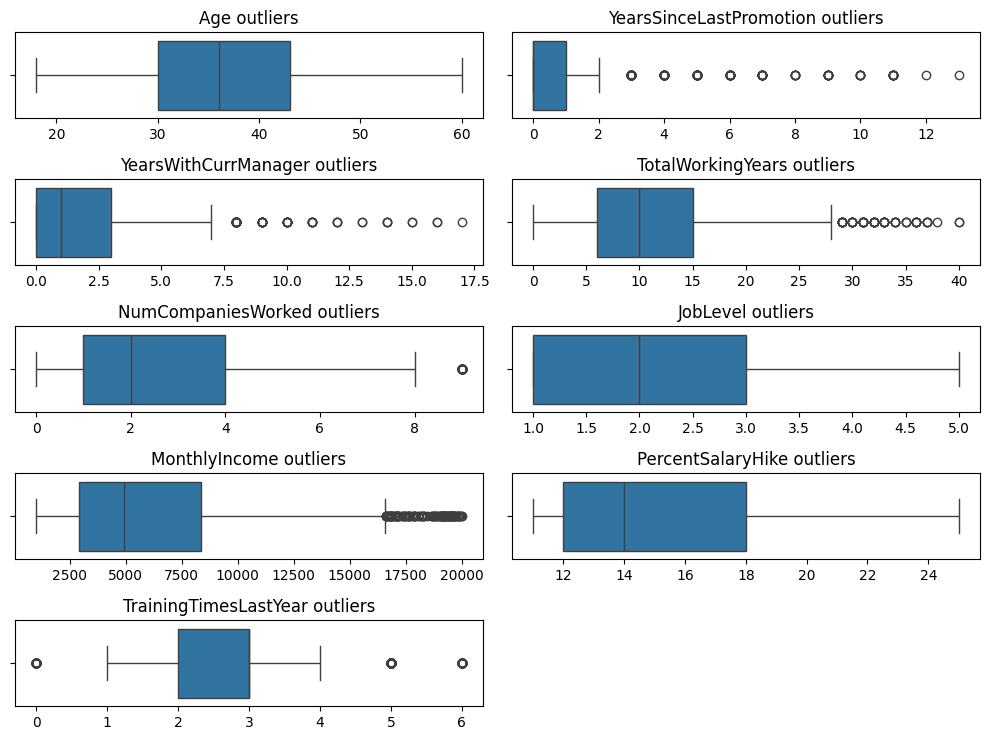

In [21]:
# Visualización de outliers en variables numéricas mediante diagramas de caja

# Seleccionar solo columnas numéricas del DataFrame
df_num = df.select_dtypes(include=np.number)
cols_num = df_num.columns

# Calcular el número de gráficos y filas necesarias
n_plots = len(cols_num)
num_rows = math.ceil(n_plots / 2)  # Se distribuyen en 2 columnas

# Ajustar dinámicamente el tamaño de la figura
width = 5 * 2
height = 1.5 * num_rows
size = (width, height)

# Crear la estructura de subplots
fig, axes = plt.subplots(nrows=num_rows, ncols=2, figsize=size)
axes = axes.flat  # Convertir matriz de ejes a lista plana

# Crear un boxplot para cada variable numérica
for i, col in enumerate(cols_num):
   sns.boxplot(
       x=col,
       data=df_num,
       ax=axes[i]
   )

   axes[i].set_title(f'{col} outliers')
   axes[i].set_xlabel('')  # Eliminar etiqueta del eje x para mayor claridad

# Eliminar el último gráfico si sobra un espacio vacío
if n_plots % 2 != 0:
   fig.delaxes(axes[-1])

# Ajustar el layout y mostrar la figura
plt.tight_layout()
plt.show()


### Detección de outliers mediante el método IQR

In [22]:
# Diccionario para almacenar los outliers detectados en cada columna
outliers_dict_iqr = {}

# Iterar sobre cada columna numérica
for col in df_num.columns:
   # Calcular los cuartiles Q1 y Q3
   Q1 = df_num[col].quantile(0.25)
   Q3 = df_num[col].quantile(0.75)
   IQR = Q3 - Q1  # Calcular el rango intercuartil

   # Definir los límites para detectar outliers (método de la valla)
   lower_bound = Q1 - 1.5 * IQR
   upper_bound = Q3 + 1.5 * IQR

   # Filtrar los outliers en la columna actual
   outliers = df_num[(df_num[col] < lower_bound) | (df_num[col] > upper_bound)]
   
   # Almacenar los outliers en el diccionario
   outliers_dict_iqr[col] = outliers

In [19]:
outliers_dict_iqr['YearsSinceLastPromotion']

,Age,YearsSinceLastPromotion,YearsWithCurrManager,TotalWorkingYears,NumCompaniesWorked,JobLevel,MonthlyIncome,PercentSalaryHike,TrainingTimesLastYear
22,58,9,1,40,7.0,5,19246,12,2
23,44,3,6,23,3.0,4,13320,18,2
26,52,9,2,34,0.0,5,19999,14,5
31,52,4,2,33,1.0,5,19845,15,3
47,39,4,3,17,4.0,2,5902,14,1
...,...,...,...,...,...,...,...,...,...
1433,30,4,2,6,0.0,2,6577,11,6
1443,40,6,0,9,1.0,2,4661,13,4
1449,30,6,3,12,0.0,1,2564,14,2
1465,30,3,6,12,1.0,2,4011,23,2


### Detección de outliers mediante el método Z-score

In [23]:
# Diccionario para almacenar los outliers detectados en cada columna
outliers_dict_z = {}

for col in df_num.columns:

    # Filtrar los outliers usando |Z| > 3
    outliers = df_num[np.abs(zscore(df_num[col])) > 3]

    # Almacenar los outliers en el diccionario
    outliers_dict_z[col] = outliers

outliers_df = pd.concat(outliers_dict_z.values(), keys=outliers_dict_z.keys())


In [26]:
outliers_dict_z['YearsSinceLastPromotion'].shape

(46, 9)

---

## Para regresión

La variable objetivo es `MonthlyIncome`

In [27]:
# Hacemos una copia del DataFrame
df_reg = df.copy()

# Seleccionamos la variable objetivo
tv = 'MonthlyIncome'

### Codificación

In [28]:
cat_cols = df_reg.select_dtypes(include='O').columns.to_list()

In [29]:
cat_cols

['Education',
 'EducationField',
 'Gender',
 'MaritalStatus',
 'Country',
 'Attrition',
 'BusinessTravel',
 'Department',
 'JobRole',
 'OverTime',
 'EnvironmentSatisfaction',
 'JobInvolvement',
 'JobSatisfaction',
 'RelationshipSatisfaction']

Selección de los métodos de codificación

In [33]:
onehot_cols = ['Gender', 'MaritalStatus', 'OverTime', 'Attrition']
target_cols = [x for x in cat_cols if x not in onehot_cols]

`OneHotEncoding`

In [35]:
# Codificación OneHot
onehot_encoder = OneHotEncoder(drop=None, sparse_output=False, handle_unknown='ignore')
onehot_encoded = onehot_encoder.fit_transform(df_reg[onehot_cols])
onehot_feature_names = onehot_encoder.get_feature_names_out()
df_onehot = pd.DataFrame(onehot_encoded, columns=onehot_feature_names, index=df_reg.index)

# Concatenar con el DataFrame original y eliminar las columnas originales
df_reg = pd.concat([df_reg.drop(columns=onehot_cols), df_onehot], axis=1)

`TargetEncoding`

In [37]:
# Codificación Target Encoding para algunas variables categóricas con category_encoders
target_encoder = TargetEncoder(cols=target_cols)
df_reg[target_cols] = target_encoder.fit_transform(df_reg[target_cols], df_reg[tv])

### Escalado

`MinMaxScaler`

In [39]:
scaler = MinMaxScaler()
df_reg[df_reg.drop(columns=[tv]).columns] = scaler.fit_transform(df_reg.drop(columns=[tv]))

### Guardamos el dataframe preprocesado

In [42]:
df_reg.to_csv('df_regresion.csv')

---

## Para clasificación

La variable objetivo es `Attrition`

In [43]:
# Hacemos una copia del DataFrame
df_clas = df.copy()

# Seleccionamos la variable objetivo
tv = 'Attrition'

### Codificación

In [44]:
cat_cols = df_clas.select_dtypes(include='O').columns.to_list()

Selección de los métodos de codificación

In [45]:
onehot_cols = ['Gender', 'MaritalStatus', 'OverTime']

target_cols = ['Education', 'Department', 'EducationField', 'JobRole', 'EnvironmentSatisfaction', 'JobInvolvement', 
              'JobSatisfaction', 'RelationshipSatisfaction']

label_cols = ['EducationField', 'Country', 'BusinessTravel', 'Department']

`OneHotEncoding`

In [46]:
# Codificación OneHot
onehot_encoder = OneHotEncoder(drop=None, sparse_output=False, handle_unknown='ignore')
onehot_encoded = onehot_encoder.fit_transform(df_clas[onehot_cols])
onehot_feature_names = onehot_encoder.get_feature_names_out()
df_onehot = pd.DataFrame(onehot_encoded, columns=onehot_feature_names, index=df_clas.index)

# Concatenar con el DataFrame original y eliminar las columnas originales
df_clas = pd.concat([df_clas.drop(columns=onehot_cols), df_onehot], axis=1)

Variable objetivo a la que hacer target encoding

In [ ]:
# Convertir la variable objetivo a numérica
df_clas['Attrition'] = df_clas['Attrition'].map({'Yes': 1, 'No': 0})

`TargetEncoding`

In [48]:
# Codificación Target Encoding para algunas variables categóricas con category_encoders
target_encoder = TargetEncoder(cols=target_cols)
df_clas[target_cols] = target_encoder.fit_transform(df_clas[target_cols], df_clas[tv])

`LabelEncoding`

In [49]:
# Para LabelEncoding necesitamos aplicarlo a las columnas de una en una
df_clas[label_cols] = df_clas[label_cols].apply(lambda col: LabelEncoder().fit_transform(col))

### Escalado

`MinMaxScaler`

In [50]:
scaler = MinMaxScaler()
df_clas[df_clas.columns] = scaler.fit_transform(df_clas)

### Guardamos el dataframe preprocesado

In [52]:
df_clas.to_csv('df_clasificacion.csv')